In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from prophet import Prophet
from mango import scheduler, Tuner

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

In [3]:
df.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)
df

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
Test_size = int(40) #last 40 values
train_df = df.head(len(df)-Test_size)
test_df = df.tail(Test_size)

In [5]:
#define loss function
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred)/y_true))*100, 2)

In [6]:
param_space = dict(growth = ['linear', 'logistic', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000]
                   )

In [7]:
def objective_function(args_list):
    global train_df, test_df

    params_evaluated = []
    results = []

    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=Test_size, freq='M')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(Test_size)
            error = mape(test_df['y'], predictions_tuned['yhat'])

            params_evaluated.append(params)
            results.append(error)
        except:
            #print(f"Exception raised for {params}")
            #pass
            params_evaluated.append(params)
            results.append(25.0)# Giving high loss for exceptions regions of spaces

        #print(params_evaluated, mse)
    return params_evaluated, results

In [8]:
conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50

tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

best parameters: {'changepoint_prior_scale': 0.025850693382894332, 'changepoint_range': 0.5250636575570811, 'daily_seasonality': True, 'growth': 'linear', 'interval_width': 0.2722969637118573, 'n_changepoints': 45, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.308219686838006, 'uncertainty_samples': 1500, 'weekly_seasonality': True, 'yearly_seasonality': True}
best loss: 3.86


In [9]:
best_parameters = results['best_params']

model = Prophet(**best_parameters)
model.fit(train_df)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [10]:
future = model.make_future_dataframe(periods=2*Test_size, freq='M')

In [11]:
forecast = model.predict(future)

In [12]:
predictions_tuned = forecast.tail(Test_size)

In [13]:
predictions_tuned

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
144,1960-12-31,629.648713,445.248279,452.414603,628.317907,631.034855,-0.224098,-0.224098,-0.224098,-0.287083,...,0.009700,0.009700,0.009700,-0.072685,-0.072685,-0.072685,0.0,0.0,0.0,448.886969
145,1961-01-31,633.573465,429.067479,435.854852,632.174290,635.022323,-0.224098,-0.224098,-0.224098,-0.317606,...,-0.010528,-0.010528,-0.010528,-0.082981,-0.082981,-0.082981,0.0,0.0,0.0,432.346491
146,1961-02-28,637.118403,489.543648,496.334995,635.671462,638.612306,-0.224098,-0.224098,-0.224098,-0.227598,...,-0.010528,-0.010528,-0.010528,0.007027,0.007027,0.007027,0.0,0.0,0.0,492.111684
147,1961-03-31,641.043155,481.941627,489.656994,639.564836,642.581020,-0.224098,-0.224098,-0.224098,-0.242854,...,0.001445,0.001445,0.001445,-0.020202,-0.020202,-0.020202,0.0,0.0,0.0,485.363179
148,1961-04-30,644.841302,491.401876,498.341624,643.258647,646.471531,-0.224098,-0.224098,-0.224098,-0.232291,...,0.000407,0.000407,0.000407,-0.008600,-0.008600,-0.008600,0.0,0.0,0.0,495.050680
149,1961-05-31,648.766055,555.985509,562.772549,647.088593,650.452639,-0.224098,-0.224098,-0.224098,-0.137648,...,-0.002275,-0.002275,-0.002275,0.088725,0.088725,0.088725,0.0,0.0,0.0,559.464908
150,1961-06-30,652.564202,630.172308,637.833399,650.844873,654.399503,-0.224098,-0.224098,-0.224098,-0.028532,...,0.001445,0.001445,0.001445,0.194121,0.194121,0.194121,0.0,0.0,0.0,633.945478
151,1961-07-31,656.488954,603.980906,611.659790,654.721448,658.394371,-0.224098,-0.224098,-0.224098,-0.073634,...,-0.005344,-0.005344,-0.005344,0.155807,0.155807,0.155807,0.0,0.0,0.0,608.148782
152,1961-08-31,660.413707,539.763359,546.641253,658.578808,662.380752,-0.224098,-0.224098,-0.224098,-0.177422,...,0.006595,0.006595,0.006595,0.040080,0.040080,0.040080,0.0,0.0,0.0,543.241555
153,1961-09-30,664.211854,468.948658,476.435262,662.300097,666.217143,-0.224098,-0.224098,-0.224098,-0.288294,...,0.009700,0.009700,0.009700,-0.073896,-0.073896,-0.073896,0.0,0.0,0.0,472.723715


In [14]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,143.056577,99.173623,106.036285,143.056577,143.056577,-0.224098,-0.224098,-0.224098,-0.281921,...,0.009700,0.009700,0.009700,-0.067523,-0.067523,-0.067523,0.0,0.0,0.0,102.725895
1,1949-02-01,145.639932,94.324178,101.498981,145.639932,145.639932,-0.224098,-0.224098,-0.224098,-0.327813,...,-0.010528,-0.010528,-0.010528,-0.093188,-0.093188,-0.093188,0.0,0.0,0.0,97.897308
2,1949-03-01,147.973284,111.288818,118.657663,147.973284,147.973284,-0.224098,-0.224098,-0.224098,-0.220361,...,-0.010528,-0.010528,-0.010528,0.014265,0.014265,0.014265,0.0,0.0,0.0,115.365809
3,1949-04-01,150.556639,111.807229,118.683929,150.556639,150.556639,-0.224098,-0.224098,-0.224098,-0.233565,...,0.001445,0.001445,0.001445,-0.010912,-0.010912,-0.010912,0.0,0.0,0.0,115.391939
4,1949-05-01,153.056659,113.550913,120.384144,153.056659,153.056659,-0.224098,-0.224098,-0.224098,-0.235849,...,0.000407,0.000407,0.000407,-0.012159,-0.012159,-0.012159,0.0,0.0,0.0,116.958423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1963-11-30,764.356340,530.818786,538.764873,760.581705,767.967209,-0.224098,-0.224098,-0.224098,-0.300512,...,0.009700,0.009700,0.009700,-0.086114,-0.086114,-0.086114,0.0,0.0,0.0,534.657895
180,1963-12-31,768.281092,525.451919,534.078253,764.430994,771.965572,-0.224098,-0.224098,-0.224098,-0.310948,...,-0.010528,-0.010528,-0.010528,-0.076323,-0.076323,-0.076323,0.0,0.0,0.0,529.385536
181,1964-01-31,772.205845,537.943904,546.759923,768.340529,775.977135,-0.224098,-0.224098,-0.224098,-0.297865,...,0.001445,0.001445,0.001445,-0.075213,-0.075213,-0.075213,0.0,0.0,0.0,542.192733
182,1964-02-29,775.877387,611.419863,620.328459,771.963702,779.666574,-0.224098,-0.224098,-0.224098,-0.205439,...,0.009700,0.009700,0.009700,0.008959,0.008959,0.008959,0.0,0.0,0.0,616.481580


In [17]:
new_df = pd.DataFrame()
new_df['ds'] = forecast.ds
new_df['y'] = df.y

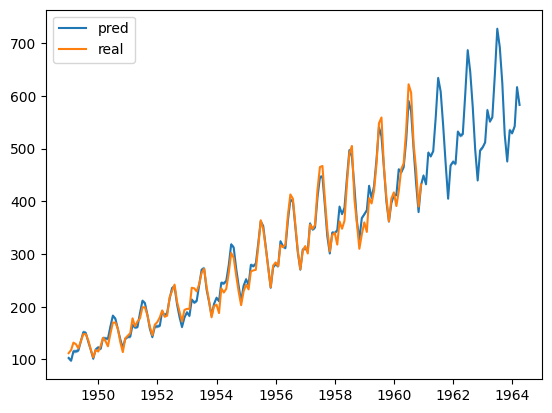

In [44]:
fig = plt.plot(forecast.ds, forecast.yhat, label='pred')
plt.plot(forecast.ds, new_df.y, label='real')
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, alpha=0.5)
plt.legend()
plt.show()

In [22]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,143.056577,99.173623,106.036285,143.056577,143.056577,-0.224098,-0.224098,-0.224098,-0.281921,...,0.009700,0.009700,0.009700,-0.067523,-0.067523,-0.067523,0.0,0.0,0.0,102.725895
1,1949-02-01,145.639932,94.324178,101.498981,145.639932,145.639932,-0.224098,-0.224098,-0.224098,-0.327813,...,-0.010528,-0.010528,-0.010528,-0.093188,-0.093188,-0.093188,0.0,0.0,0.0,97.897308
2,1949-03-01,147.973284,111.288818,118.657663,147.973284,147.973284,-0.224098,-0.224098,-0.224098,-0.220361,...,-0.010528,-0.010528,-0.010528,0.014265,0.014265,0.014265,0.0,0.0,0.0,115.365809
3,1949-04-01,150.556639,111.807229,118.683929,150.556639,150.556639,-0.224098,-0.224098,-0.224098,-0.233565,...,0.001445,0.001445,0.001445,-0.010912,-0.010912,-0.010912,0.0,0.0,0.0,115.391939
4,1949-05-01,153.056659,113.550913,120.384144,153.056659,153.056659,-0.224098,-0.224098,-0.224098,-0.235849,...,0.000407,0.000407,0.000407,-0.012159,-0.012159,-0.012159,0.0,0.0,0.0,116.958423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1963-11-30,764.356340,530.818786,538.764873,760.581705,767.967209,-0.224098,-0.224098,-0.224098,-0.300512,...,0.009700,0.009700,0.009700,-0.086114,-0.086114,-0.086114,0.0,0.0,0.0,534.657895
180,1963-12-31,768.281092,525.451919,534.078253,764.430994,771.965572,-0.224098,-0.224098,-0.224098,-0.310948,...,-0.010528,-0.010528,-0.010528,-0.076323,-0.076323,-0.076323,0.0,0.0,0.0,529.385536
181,1964-01-31,772.205845,537.943904,546.759923,768.340529,775.977135,-0.224098,-0.224098,-0.224098,-0.297865,...,0.001445,0.001445,0.001445,-0.075213,-0.075213,-0.075213,0.0,0.0,0.0,542.192733
182,1964-02-29,775.877387,611.419863,620.328459,771.963702,779.666574,-0.224098,-0.224098,-0.224098,-0.205439,...,0.009700,0.009700,0.009700,0.008959,0.008959,0.008959,0.0,0.0,0.0,616.481580
